# CalTech 101

Now that we have learned how to do Transfer Learning, let's try to use it on larger Datasets. We will study the [CalTech101] dataset (http://www.vision.caltech.edu/Image_Datasets/Caltech101/) which contains 40 to 800 images from 101 categories. 

1. Import the classic librairies 

In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader
from pathlib import Path
import scipy
import shutil
import os
import json
import matplotlib.pyplot as plt

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


2. Using [`datasets.Caltech101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Caltech101.html), download and extract the Caltech101 dataset.

In [126]:
# Doesn't seems to work anymore, downloading directly on https://data.caltech.edu/

# Data Augmentation

We will now proceed to the preprocessing of our data. The easiest way to do so is using a composition of several transform functions from `torchvision.transforms.v2`.
The target shapes of our images should be `(299,299)`.

In [127]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    # Make sure images are converted to RGB format with 3 channels even if they are originally in grayscale
    transforms.RGB(),

    # Randomly flip the image horizontally (left-right) with a probability of 50%
    transforms.RandomHorizontalFlip(),

    # Randomly flip the image vertically (up-down) with a probability of 50%
    transforms.RandomVerticalFlip(),

    # Randomly adjust brightness and contrast (±20% variation)
    transforms.ColorJitter(brightness=0.2),

    # Resize the image to match the required input size for models like InceptionV3 (299x299 pixels)
    transforms.Resize((299, 299)),

    # Convert the image to a PyTorch tensor (channels-first format: C x H x W)
    transforms.ToTensor(),

    # Normalize pixel values to range [-1, 1] using mean and standard deviation
    transforms.Normalize(mean=[0.5], std=[0.5])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning:

The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.



2. Prepare two objects `train_loader` and `val_loader` using the `datasets.ImageFolder` class.
Form batches of 32 images, make sure you use an option to drop the last batch as you may run into trouble if the last bactch contains only one image. (You may leave the drop_last argument blank, and witness the thick opacity of the error message you'll get 🤭)

In [128]:
data_root = Path("caltech-101/101_ObjectCategories")

for item in data_root.iterdir():
  print(item)  

caltech-101/101_ObjectCategories/gerenuk
caltech-101/101_ObjectCategories/hawksbill
caltech-101/101_ObjectCategories/headphone
caltech-101/101_ObjectCategories/ant
caltech-101/101_ObjectCategories/butterfly
caltech-101/101_ObjectCategories/lamp
caltech-101/101_ObjectCategories/strawberry
caltech-101/101_ObjectCategories/water_lilly
caltech-101/101_ObjectCategories/chandelier
caltech-101/101_ObjectCategories/dragonfly
caltech-101/101_ObjectCategories/crab
caltech-101/101_ObjectCategories/pagoda
caltech-101/101_ObjectCategories/dollar_bill
caltech-101/101_ObjectCategories/emu
caltech-101/101_ObjectCategories/inline_skate
caltech-101/101_ObjectCategories/platypus
caltech-101/101_ObjectCategories/dalmatian
caltech-101/101_ObjectCategories/cup
caltech-101/101_ObjectCategories/airplanes
caltech-101/101_ObjectCategories/.DS_Store
caltech-101/101_ObjectCategories/joshua_tree
caltech-101/101_ObjectCategories/cougar_body
caltech-101/101_ObjectCategories/grand_piano
caltech-101/101_ObjectCategori

In [129]:
# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_root, transform=transform)

# Load image from the folder using image folder

# Get class names
class_names = dataset.classes

# split data into train and validation set
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create the data loaders for the train set and validation set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)

3. Visualize a batch of images coming from the train set. Do you notice anyhting we will have to take into consideration when building the model?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.69411767].


Label : Faces


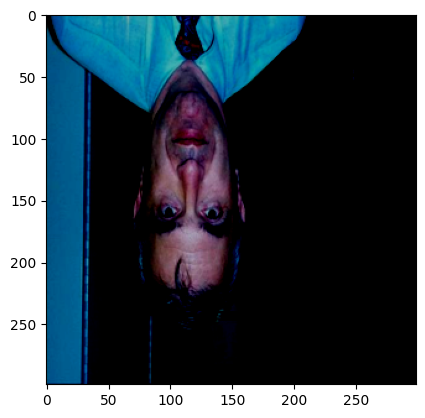

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.84313726].


Label : dragonfly


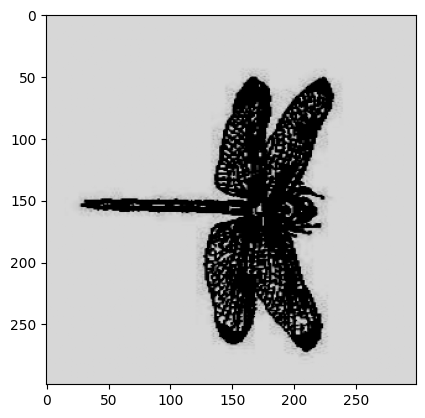

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Label : grand_piano


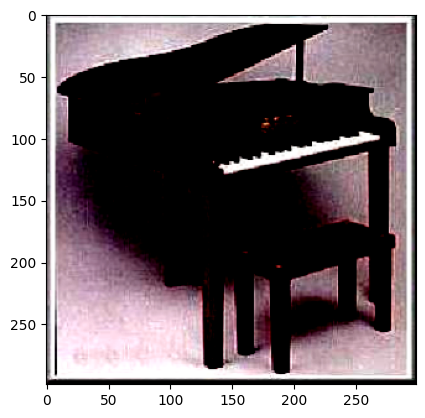

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Label : watch


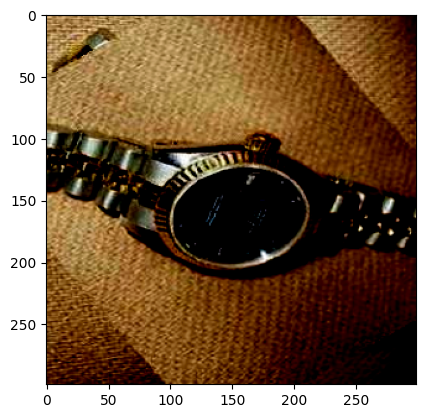

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].


Label : minaret


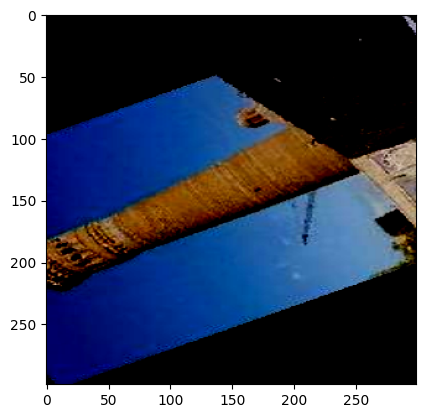

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].


Label : Motorbikes


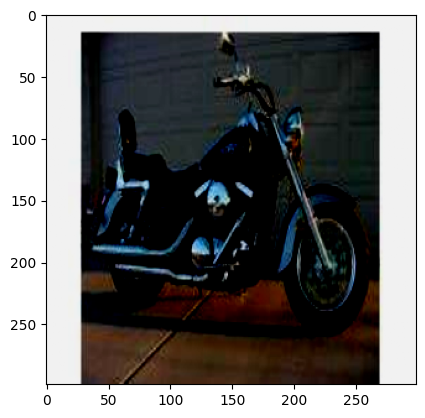

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


Label : headphone


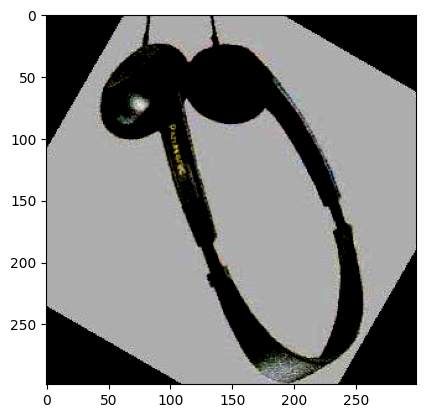

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].


Label : Faces_easy


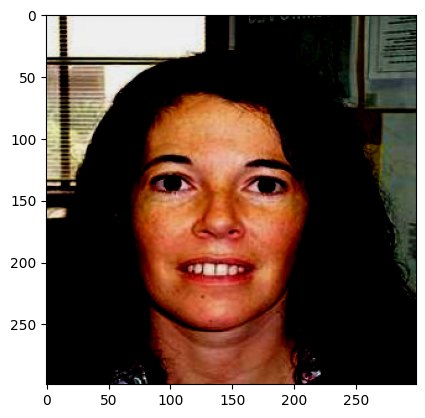

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Label : cannon


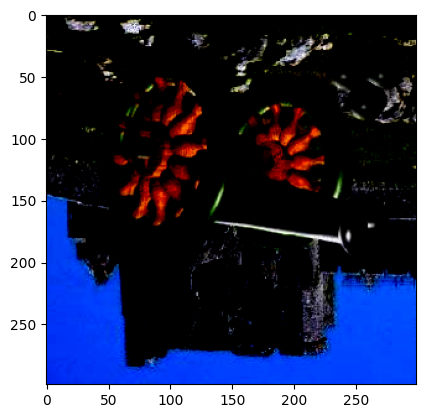

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Label : starfish


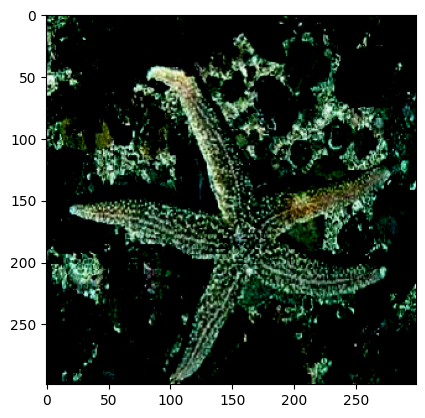

In [130]:

imgs, labels = next(iter(train_loader))

for i, (img, label) in enumerate(zip(imgs, labels)):

  true_label_name = class_names[label]

  print("Label :", true_label_name)

  plt.imshow(img.permute(1, 2, 0).numpy())
  plt.show()
  
  if i==9: break

# Transfer Learning

1. Import a pretrained model from tensorflow, the solution will use the example of <a href="https://pytorch.org/vision/main/models/generated/torchvision.models.inception_v3.html"> InceptionV3 </a>, but feel free to use different architecture if you would like to get a different point of view. Make sure you use the pretrained weights from `imagenet`.

In [131]:
# Load a pre-trained model (Inception v3)
model = models.inception_v3(weights="IMAGENET1K_V1")

In [132]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [133]:
from torchinfo import summary

# Print model summary
summary(model, input_size=(1, 3, 299, 299))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [1, 1000]                 3,326,696
├─BasicConv2d: 1-1                       [1, 32, 149, 149]         --
│    └─Conv2d: 2-1                       [1, 32, 149, 149]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 149, 149]         64
├─BasicConv2d: 1-2                       [1, 32, 147, 147]         --
│    └─Conv2d: 2-3                       [1, 32, 147, 147]         9,216
│    └─BatchNorm2d: 2-4                  [1, 32, 147, 147]         64
├─BasicConv2d: 1-3                       [1, 64, 147, 147]         --
│    └─Conv2d: 2-5                       [1, 64, 147, 147]         18,432
│    └─BatchNorm2d: 2-6                  [1, 64, 147, 147]         128
├─MaxPool2d: 1-4                         [1, 64, 73, 73]           --
├─BasicConv2d: 1-5                       [1, 80, 73, 73]           --
│    └─Conv2d: 2-7                       [1, 80, 73, 73]           5,

2. Set the weights of your imported model as non-trainable 

In [134]:
# Freeze the feature extraction layers
for param in model.parameters():
    
    param.requires_grad = False

3. Create now your complete model by adding the last layer adapted to your situation 

In [135]:
# Modify the final classification layer to match the number of classes
num_classes = len(train_dataset.dataset.classes)

model.fc = nn.Sequential(
    # fully connected layer with num_classes neurons
    nn.Linear(model.fc.in_features, num_classes),
    
    # Softmax activation for classification
    nn.Softmax(dim=1)
)

model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

4. Compile your model with [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) using Adam with a learning rate of `0.001` and the appropriate loss and metrics. 

In [136]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)  # Move loss function to MPS

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


5. Train your model and monitor the overfitting using the validation data for 5 epochs.

In [137]:
# Training function for a PyTorch model
def train(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    """
    Function to train a PyTorch model and evaluate it on a validation set.

    Parameters:
    - model: The neural network model to be trained.
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation dataset.
    - criterion: Loss function (e.g., CrossEntropyLoss for classification).
    - optimizer: Optimization algorithm (e.g., Adam, SGD).
    - epochs: Number of training epochs (default = 50).

    Returns:
    - history: Dictionary containing loss and accuracy for both training and validation.
    """

    # Dictionary to store loss and accuracy values for each epoch
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    
    # Loop through the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize loss and correct predictions
        
        # Training loop - iterate through batches in the training set
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  # Reset gradients before each batch
            logit, aux_logit = model(inputs)  # Forward pass: Get predictions
            loss = criterion(logit, labels)  # Compute loss
            loss.backward()  # Backpropagation: Compute gradients
            optimizer.step()  # Update model parameters using optimizer
            
            total_loss += loss.item()  # Accumulate total loss
            correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions
        
        # Compute average loss and accuracy for the training set
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        
        # Validation phase (no gradient calculation needed)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # Disable gradient calculation for efficiency
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                logit = model(inputs)  # Forward pass
                _, preds = torch.max(logit, 1) # extract predictions
                loss = criterion(logit, labels.data)  # Compute validation loss
                val_loss += loss.item()  # Accumulate validation loss
                val_correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions
        
        # Compute average loss and accuracy for the validation set
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)
        
        # Store training and validation metrics for analysis
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        # Print progress after each epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return history  # Return training history

# Train the model and store the training history
history = train(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch [1/5], Loss: 4.3834, Acc: 0.2880, Val Loss: 4.2626, Val Acc: 0.4012
Epoch [2/5], Loss: 4.2351, Acc: 0.4270, Val Loss: 4.1964, Val Acc: 0.4552
Epoch [3/5], Loss: 4.1837, Acc: 0.4731, Val Loss: 4.1399, Val Acc: 0.5106
Epoch [4/5], Loss: 4.1129, Acc: 0.5517, Val Loss: 4.0683, Val Acc: 0.5849
Epoch [5/5], Loss: 4.0588, Acc: 0.6017, Val Loss: 4.0386, Val Acc: 0.6137


In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Training function for a PyTorch model
# This function is responsible for training a neural network and evaluating it on a validation set.

# Parameters:
# - model: The neural network model to be trained.
# - train_loader: DataLoader for the training dataset.
# - val_loader: DataLoader for the validation dataset.
# - criterion: Loss function (e.g., CrossEntropyLoss for classification).
# - optimizer: Optimization algorithm (e.g., Adam, SGD).
# - epochs: Number of training epochs (default = 50).

# Returns:
# - history: Dictionary containing loss and accuracy for both training and validation.

# Dictionary to store loss and accuracy values for each epoch.

# Loop through the specified number of epochs.

# Set model to training mode.

# Initialize loss and correct predictions.

# Training loop - iterate through batches in the training set.

# Move inputs and labels to the same device as the model.

# Reset gradients before each batch.

# Forward pass: Get predictions from the model.

# Compute loss using the criterion.

# Backpropagation: Compute gradients.

# Update model parameters using the optimizer.

# Accumulate total loss.

# Count correct predictions.

# Compute average loss and accuracy for the training set.

# Validation phase (no gradient calculation needed).

# Set model to evaluation mode.

# Disable gradient calculation for efficiency.

# Iterate through the validation set.

# Skip iteration if batch size is 1 (to avoid issues with certain models).

# Move inputs and labels to the same device as the model.

# Forward pass to get predictions.

# Extract predictions from logits.

# Compute validation loss.

# Accumulate validation loss.

# Count correct predictions.

# Compute average loss and accuracy for the validation set.

# Store training and validation metrics for analysis.

# Print progress after each epoch.

# Return training history for later analysis.


6. Save the model to file, so you can later load your trained model without having to go through training again.

In [139]:
# Save model checkpoint 
checkpoint_path = "model_conv_transfer_1.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': history["val_loss"][-1],
    'history': history 
}, checkpoint_path)

6. Visualize your `accuracy` on your `train` and on your `test` thanks to the attribute `history` of your model

In [140]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["accuracy"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_accuracy"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

7. Do the same for your `loss`

In [141]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

# Fine-Tuning

1. Count the number of layers in your pre-trained model

In [142]:
# Load the base model
model = models.inception_v3(weights="IMAGENET1K_V1")

i = 0

# count the elements thanks to the .modules() method
for m in model.modules():
    # Includes all submodules
    i += 1
    
i

307

2. Let about 10% of the layers towards the top in trainable status and freeze the rest. You will have to load the pre-trained model again.

In [ ]:
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Unfreeze last 30 layers for fine-tuning
fine_tune_at = len(list(model.children())) - 30

for param in list(model.parameters())[:fine_tune_at]:
    param.requires_grad = False

model = model.to(device)

In [ ]:
# Print model summary
summary(model, input_size=(1, 3, 299, 299))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [1, 102]                  3,326,696
├─BasicConv2d: 1-1                       [1, 32, 149, 149]         --
│    └─Conv2d: 2-1                       [1, 32, 149, 149]         (864)
│    └─BatchNorm2d: 2-2                  [1, 32, 149, 149]         (64)
├─BasicConv2d: 1-2                       [1, 32, 147, 147]         --
│    └─Conv2d: 2-3                       [1, 32, 147, 147]         (9,216)
│    └─BatchNorm2d: 2-4                  [1, 32, 147, 147]         (64)
├─BasicConv2d: 1-3                       [1, 64, 147, 147]         --
│    └─Conv2d: 2-5                       [1, 64, 147, 147]         (18,432)
│    └─BatchNorm2d: 2-6                  [1, 64, 147, 147]         (128)
├─MaxPool2d: 1-4                         [1, 64, 73, 73]           --
├─BasicConv2d: 1-5                       [1, 80, 73, 73]           --
│    └─Conv2d: 2-7                       [1, 80, 73, 73] 

5. Train the model for 5 epochs.

In [149]:
# define the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# start training
history_finetune = train(model, train_loader, val_loader, criterion, optimizer, epochs=5)


Epoch [1/5], Loss: 1.7198, Acc: 0.6486, Val Loss: 0.6292, Val Acc: 0.8440
Epoch [2/5], Loss: 0.5330, Acc: 0.8645, Val Loss: 0.4604, Val Acc: 0.8681
Epoch [3/5], Loss: 0.3590, Acc: 0.9020, Val Loss: 0.3708, Val Acc: 0.8950
Epoch [4/5], Loss: 0.2664, Acc: 0.9303, Val Loss: 0.3803, Val Acc: 0.8848
Epoch [5/5], Loss: 0.2273, Acc: 0.9372, Val Loss: 0.3611, Val Acc: 0.8958


In [150]:
# Save model checkpoint 
checkpoint_path = "model_conv_transfer_2.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': history_finetune["val_loss"][-1],
    'history': history_finetune 
}, checkpoint_path)

6. Visualize your `accuracy` on your `train` and on your `test` 

In [151]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history_finetune["accuracy"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_finetune["val_accuracy"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

7. Do the same for your `loss`

In [152]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history_finetune["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_finetune["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

# Interpretation with Grad Cam

1. Create an object `imgs` and an object `labels` containing a batch of validation images and validation labels.

2. Get the name of the last convolution layer of the pretrained model.

The last convolutional layer is called `Mixes_7c`.

3. Produce the grad cam for all images in the batch

In [ ]:
import requests
import json

# Convert into a dictionary of {class_idx: class_name}

# Example: Get class name for index 4
  # Output: 'Motorbikes'


In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1️⃣ Load the Pretrained InceptionV3 model
# Set to evaluation mode

# 2️⃣ Choose the target layer (the last convolutional layer)

# 3️⃣ Preprocessing Function for Files
# Define a function to preprocess images by resizing, normalizing, and converting them to tensors.

    # Resize the image to the required input size for InceptionV3 (299x299 pixels)
    
    # Convert the image to a PyTorch tensor
    
    # Normalize pixel values to match the expected input distribution

    # Open the image, convert to RGB, apply transformations, and add a batch dimension

# 4️⃣ Hook to Extract Gradients & Features
# Define the GradCAM class to extract feature maps and gradients from a target layer.

    # Initialize the model, target layer, and storage for gradients & features
    
    # Register hooks for capturing the intermediate layer's forward and backward passes

    # Hook function to store feature maps during the forward pass

    # Hook function to store gradients during the backward pass

    # Generate Grad-CAM heatmap from an input tensor
    
        # Perform a forward pass through


In [ ]:
# 🔥 **Test with an Image**
  # Replace with your image path
    # 🔥 **Test with a Tensor**
     # Remove batch dimension
    


This grad cam logic helps us dive deeper into the model's stength, and weakness, as well as identify biases in out dataset.

4. What bias can you identify in our dataset that the grad cam enables us to pickup, and how could we solve this problem ?